In [1]:
import os
import tensorflow as tf
import numpy as np
from mlp.data_providers import CIFAR10DataProvider
import matplotlib.pyplot as plt
import time

In [2]:
class AugmentedCIFAR10DataProvider(CIFAR10DataProvider):

    def __init__(self, which_set='train', batch_size=50, max_num_batches=-1,
                 shuffle_order=True, rng=None, transformer=None):
        super(AugmentedCIFAR10DataProvider, self).__init__(
            which_set, batch_size, max_num_batches, shuffle_order, rng)
        self.transformer = transformer

    def next(self):
        inputs_batch, targets_batch = super(
            AugmentedCIFAR10DataProvider, self).next()
        transformed_inputs_batch = self.transformer(inputs_batch, self.rng)
        return transformed_inputs_batch, targets_batch

In [3]:
def random_Gaussian(inputs, rng):
    orig_ims = inputs.reshape((-1, 32, 32, 3))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for j in (indices):
        new_ims[j] = orig_ims[j]*np.random.normal(0,0.8)
    return new_ims.reshape((-1, 1024))

In [4]:
random_seed = 1627522
rng = np.random.RandomState(random_seed)

train_data = CIFAR10DataProvider('train', batch_size=50, rng=rng)
valid_data = CIFAR10DataProvider('valid', batch_size=50, rng=rng)

In [5]:
rng = np.random.RandomState(123456)
def random_fliplr(inputs, rng):
    orig_ims = inputs.reshape((-1, 32, 32, 3))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for i, j in enumerate(indices):
        new_ims[j] = np.fliplr(orig_ims[j])
    return new_ims.reshape((-1, 3072))

In [6]:
random_seed = 1627522
rng = np.random.RandomState(random_seed)

train_data = AugmentedCIFAR10DataProvider('train', batch_size=50, transformer=random_fliplr,rng=rng)
valid_data = CIFAR10DataProvider('valid', batch_size=50, rng=rng)

In [7]:
def fully_connected_layer(inputs, input_dim, output_dim, nonlinearity=tf.nn.relu):
    weights = tf.Variable(
        tf.truncated_normal(
            [input_dim, output_dim], stddev=2. / (input_dim + output_dim)**0.5), 
        'weights')
    biases = tf.Variable(tf.zeros([output_dim]), 'biases')
    outputs = nonlinearity(tf.matmul(inputs, weights) + biases)
    return outputs

def _variable_with_weight_decay(name, shape, stddev, wd):
    dtype = tf.float32
    var = _variable_on_cpu(name, shape,
                           tf.contrib.layers.xavier_initializer_conv2d(uniform=True, seed=None, dtype=tf.float32))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

def _variable_on_cpu(name, shape, initializer):
    dtype = tf.float32
    var = tf.get_variable(name, shape, initializer=initializer)
    return var

In [8]:
train_data.reset()
valid_data.reset()
inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')

with tf.variable_scope('conv1') as scope:
    inputs_new=tf.reshape(inputs,[50,32,32,3])
    kernel1 = _variable_with_weight_decay('conv_weights_1', shape=[3, 3, 3, 64], stddev=5e-2, wd=0.0)
    conv = tf.nn.conv2d(inputs_new, kernel1, [1, 1, 1, 1], padding='SAME')
    biases1 = _variable_on_cpu('biases_1', [64], tf.constant_initializer(0.0))
    pre_activation1 = tf.nn.bias_add(conv, biases1)
    conv1 = tf.nn.relu(pre_activation1, name=scope.name)
    
with tf.variable_scope('conv2') as scope:
    kernel2 = _variable_with_weight_decay('conv_weights_2', shape=[3, 3, 64, 64], stddev=5e-2, wd=0.0)
    conv_2 = tf.nn.conv2d(conv1, kernel2, [1, 1, 1, 1], padding='SAME')
    biases2 = _variable_on_cpu('biases_2', [64], tf.constant_initializer(0.0))
    pre_activation2 = tf.nn.bias_add(conv_2, biases2)
    conv2 = tf.nn.relu(pre_activation2, name=scope.name)

pool1 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')

num_hidden = 1000
conv2_out=tf.reshape(pool1,[50, -1])
with tf.name_scope('fc-layer-1'):
    hidden_1 = fully_connected_layer(conv2_out, 16384, num_hidden)
with tf.name_scope('output-layer'):
    outputs = fully_connected_layer(hidden_1, num_hidden, train_data.num_classes, tf.identity)

with tf.name_scope('error'):
    error = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(outputs, targets))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(
            tf.equal(tf.argmax(outputs, 1), tf.argmax(targets, 1)), 
            tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(error)
    
init = tf.global_variables_initializer()


train_data.reset()
valid_data.reset()
running_error_one = []
running_accuracy_one = []
valid_error_one = []
valid_accuracy_one = []

with tf.Session() as sess:
    sess.run(init)
    for e in range(50):
        running_error = 0.
        running_accuracy = 0.
        start_time = time.time()
        for input_batch, target_batch in train_data:
            #input_batch=random_Gaussian(input_batch,rng)
            _, batch_error, batch_acc = sess.run(
                [train_step, error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        epoch_time = time.time() - start_time
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        
        running_error_one.append(running_error)
        running_accuracy_one.append(running_accuracy)
        
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f} epoch time={3:.2f}'
              .format(e + 1, running_error, running_accuracy, epoch_time))
        
        valid_error = 0.
        valid_accuracy = 0.
        for input_batch, target_batch in valid_data:
            batch_error, batch_acc = sess.run(
                [error, accuracy], 
                feed_dict={inputs: input_batch, targets: target_batch})
            valid_error += batch_error
            valid_accuracy += batch_acc
        valid_error /= valid_data.num_batches
        valid_accuracy /= valid_data.num_batches
            
        valid_error_one.append(valid_error)
        valid_accuracy_one.append(valid_accuracy)
            
        print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                .format(valid_error, valid_accuracy))


End of epoch 01: err(train)=1.59 acc(train)=0.44 epoch time=334.86
                 err(valid)=1.37 acc(valid)=0.52


KeyboardInterrupt: 

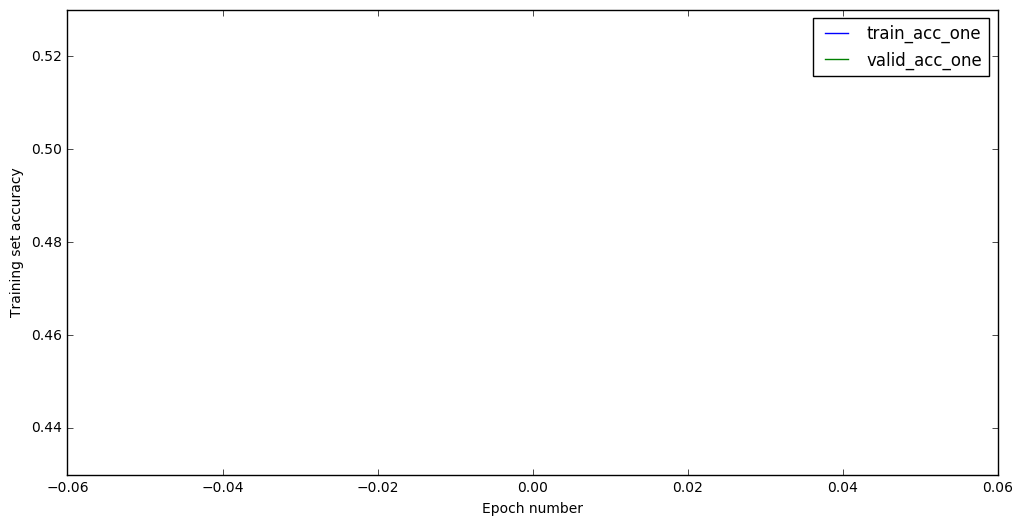

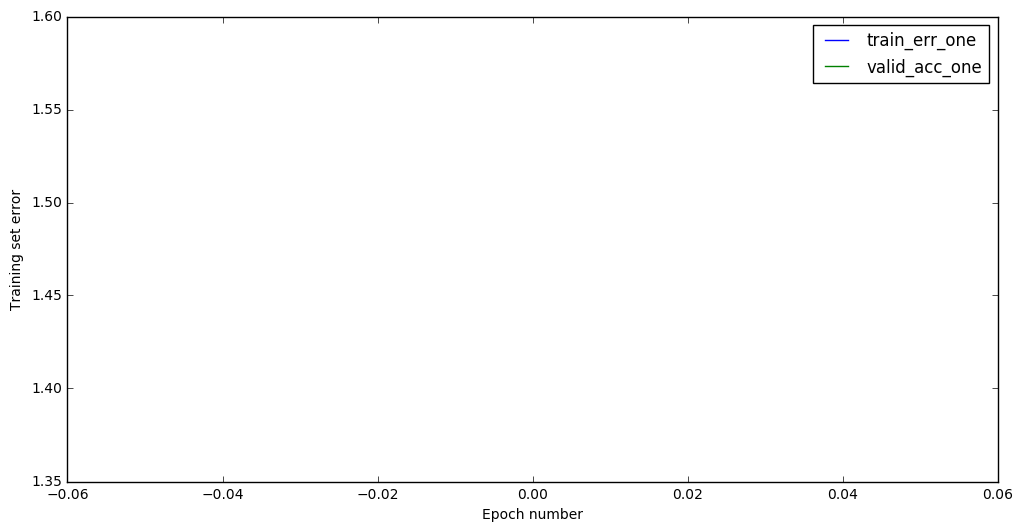

In [9]:

fig_1 = plt.figure(figsize=(12, 6))
ax1 = fig_1.add_subplot(111)
ax1.plot(running_accuracy_one, label = 'train_acc_one')
ax1.plot(valid_accuracy_one, label = 'valid_acc_one')
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set accuracy')

fig_2 = plt.figure(figsize=(12, 6))
ax2 = fig_2.add_subplot(111)
ax2.plot(running_error_one, label = 'train_err_one')
ax2.plot(valid_error_one, label = 'valid_acc_one')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Training set error')

plt.show()